In [269]:
## PYTHON LIBRARIES
# Importing libraries
import sys
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm, tqdm_notebook
import missingno as msno
import matplotlib.gridspec
from scipy import stats
import matplotlib.patches as mpatches
# Define some general functions
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from adjustText import adjust_text
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import datetime
import statsmodels

from skbio.stats.distance import anosim
from scipy.spatial.distance import squareform, pdist
from skbio import DistanceMatrix

import scikit_posthocs as sp
from scipy import stats

## WORKING DIRECTORY
path = "../analysis/plots/"

#run_type = "dry"
run_type = "wet"

run_user = "Maarouf"
#run_user = "Lisonia"

#sex = "f"
sex = "m"


new_day = datetime.datetime.now().strftime("%Y%m%d")

if run_user == "Maarouf":
    palette = {"Continuous": "#808080", "Intermittent" : "#D4D4D4", "Control":"#FFFFFF"}
    markers = {"Continuous": "s", "Intermittent" : "^", "Control":"o"}
elif run_user == "Lisonia":
    palette = {"Control":"#949494", "Intermittent": "#EA8A86", "RapamycinTrametinib":"#EBC69B", "Trametinib":"#7DF17B"}

In [270]:
# Load dataset and metadata
df = pd.read_csv("../data/plasma_normal.csv", sep = ";")
df.set_index("ID", inplace = True)
metadata = pd.read_csv("../metadata/metadata.csv", sep = "\t")
metadata.set_index("ID", inplace = True)

# Subset according to whose study it is
if run_user == "Maarouf":
    metadata = metadata[metadata["Treatment"].isin(["Continuous", "Intermittent", "Control"])]
elif run_user == "Lisonia":
    metadata = metadata[metadata["Treatment"].isin(["Control", "Intermittent", "Trametinib", "RapamycinTrametinib"])]
    
df = df[df.index.isin(metadata.index.to_list())]
mer = pd.merge(df, metadata.loc[:, ["Sex", "Treatment"]], left_index = True, right_index = True)

if sex == "f":
    mer = mer[mer["Sex"] == "f"]
elif sex == "m":
    mer = mer[mer["Sex"] == "m"]
mer.drop(columns = ["Sex"], inplace = True)

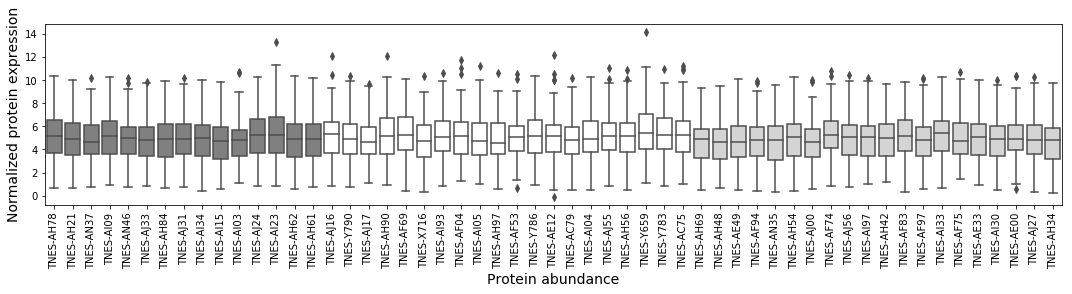

In [227]:
# Plot quality control of protein abundance
sub = mer.sort_values(["Treatment"])
intensities = sub.drop(columns = ["Treatment"]).T
palint = []

for e in sub["Treatment"]:
    palint.append(palette[e])
    
## Average intensities per sample
fig, ax = plt.subplots(figsize = (15, 4))
g = sns.boxplot(data = intensities, ax = ax, palette = palint)
plt.xticks(rotation = 90)
plt.xlabel("Protein abundance")
plt.ylabel("Normalized protein expression")
ax.yaxis.label.set_size(14)
ax.xaxis.label.set_size(14)

matplotlib.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
if run_type != "dry":
    plt.savefig(f"{path}/RawQC_protein_abundance_{sex}_{run_user}_{new_day}.pdf")
else:
    plt.show()

In [228]:
def make_pca2(in_df, a, my_pal, wd_dir, sex, run_user, my_markers, top=100):
    b = a + 1
    cols = in_df.columns
    pca = PCA(n_components = 4)
    sorted_mean = in_df.mean(axis = 1).sort_values()
    select = sorted_mean.tail(top)
    in_df = in_df.loc[select.index.values]
    pca.fit(in_df)
    temp_df = pd.DataFrame()
    temp_df['pc_{}'.format(a+1)] = pca.components_[a]
    temp_df['pc_{}'.format(b+1)] = pca.components_[b]
    temp_df.index = cols
    
    print(pca.explained_variance_ratio_)
    temp_df['color'] = my_pal
    
    fig, ax = plt.subplots(figsize = (4,4))
    temp_df.plot(kind = 'scatter', x = 'pc_{}'.format(a+1), y = 'pc_{}'.format(b+1), s = 30, 
                 c = temp_df["color"], ax = ax, edgecolors="black")
    
    ax.set_title("PCA", size = 20)
    ax.set_xlabel("PC{}_{:.3f}%".format(a+1, pca.explained_variance_ratio_[a]*100), size = 18)
    ax.set_ylabel("PC{}_{:.3f}%".format(b+1, pca.explained_variance_ratio_[b]*100), size = 18)
    
    ax.yaxis.label.set_size(18)
    ax.xaxis.label.set_size(18)
    ax.tick_params(axis = "x", labelsize = 12)
    ax.tick_params(axis = "y", labelsize = 12)
    plt.style.context('seaborn-darkgrid')
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    matplotlib.rcParams['pdf.fonttype'] = 42
    plt.tight_layout()
    
    # Calculate anosim
    pca_df = temp_df.loc[:, [f"pc_{a+1}", f"pc_{a+2}"]]
    pca_dist = pd.DataFrame(squareform(pdist(pca_df)), columns = pca_df.index, index = pca_df.index)
    pca_dist = DistanceMatrix(pca_dist)
    resanosim = anosim(pca_dist, my_pal, permutations = 999)
    print(f"Anosim test statistic: {resanosim['test statistic']}")
    print(f"Anosim p-value: {resanosim['p-value']}")
    print(f"Anosim Significant?: {resanosim['p-value'] < 0.05}")
    
    if run_type != "dry":    
        plt.savefig("{}/PCA_PCcomp_{}_{}_{}_{}.pdf".format(wd_dir, str(a + 1), sex, run_user, new_day))
    else:
        plt.show()

[0.8693312  0.04311145 0.01652407 0.01219881]
Anosim test statistic: 0.12114226804123697
Anosim p-value: 0.002
Anosim Significant?: True


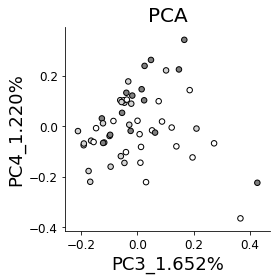

In [234]:
my_pal = []
for e in mer["Treatment"].to_list():
    my_pal.append(palette[e])
    
if run_user == "Maarouf":
    my_markers = []
    for e in mer["Treatment"].to_list():
        my_markers.append(markers[e])
elif run_user == "Lisonia":
    my_markers = "o"
    
make_pca2(mer.drop(columns = ["Treatment"]).fillna(0).T, 2, my_pal, path, sex, run_user, my_markers)

In [271]:
genes = df.columns
if run_user == "Maarouf":
    sig_genes = []
    ctrl_inter = []
    conti_inter = []
    for e in sorted(genes):
        continuous = mer[mer["Treatment"] == "Continuous"].fillna(0)[e]
        intermittent = mer[mer["Treatment"] == "Intermittent"].fillna(0)[e]
        control = mer[mer["Treatment"] == "Control"].fillna(0)[e]
        ano = stats.f_oneway(control, intermittent, continuous)
        if ano[1] < 0.05:
            sig_genes.append(e)
            print(f"\n\n----------{e}----------")
            print("Oneway")
            print(ano)
            ttestdf = pd.DataFrame({"score":list(control) + list(intermittent) + list(continuous), 
                                    "group":["control"]*len(control) + ["intermittent"]*len(intermittent) + ["continuous"]*len(continuous)})
            tte = sp.posthoc_ttest(ttestdf.fillna(0), val_col = "score", group_col = "group")
            print("T-test")
            display(tte)
            comp1 = tte.loc[["intermittent"], ["control"]]["control"][0]
            if comp1 < 0.05:
                ctrl_inter.append(e)
            comp2 = tte.loc[["intermittent"], ["continuous"]]["continuous"][0]
            if comp2 < 0.05:
                conti_inter.append(e)
    



----------Ahr----------
Oneway
F_onewayResult(statistic=3.8302073624233195, pvalue=0.030287417438485037)
T-test


,control,intermittent,continuous
control,1.000000,0.677719,0.009301
intermittent,0.677719,1.000000,0.016278
continuous,0.009301,0.016278,1.000000




----------Ccl3----------
Oneway
F_onewayResult(statistic=8.154149390916057, pvalue=0.0010998893108094612)
T-test


,control,intermittent,continuous
control,1.000000,0.006972,0.000411
intermittent,0.006972,1.000000,0.800423
continuous,0.000411,0.800423,1.000000




----------Cntn1----------
Oneway
F_onewayResult(statistic=11.744190228446211, pvalue=0.00010178272920026776)
T-test


,control,intermittent,continuous
control,1.000000,0.002691,0.000285
intermittent,0.002691,1.000000,0.205693
continuous,0.000285,0.205693,1.000000




----------Cntn4----------
Oneway
F_onewayResult(statistic=4.674791800222562, pvalue=0.015139148277241733)
T-test


,control,intermittent,continuous
control,1.000000,0.110361,0.011896
intermittent,0.110361,1.000000,0.104733
continuous,0.011896,0.104733,1.000000




----------Cyr61----------
Oneway
F_onewayResult(statistic=3.500690902121184, pvalue=0.03996940917604329)
T-test


,control,intermittent,continuous
control,1.000000,0.064190,0.023122
intermittent,0.064190,1.000000,0.662722
continuous,0.023122,0.662722,1.000000




----------Dll1----------
Oneway
F_onewayResult(statistic=4.324837609927964, pvalue=0.02011828298929711)
T-test


,control,intermittent,continuous
control,1.000000,0.019571,0.061388
intermittent,0.019571,1.000000,0.297468
continuous,0.061388,0.297468,1.000000




----------Eno2----------
Oneway
F_onewayResult(statistic=4.058749650751943, pvalue=0.025044150076305862)
T-test


,control,intermittent,continuous
control,1.000000,0.182438,0.014074
intermittent,0.182438,1.000000,0.121671
continuous,0.014074,0.121671,1.000000




----------Epo----------
Oneway
F_onewayResult(statistic=4.933919051036293, pvalue=0.012297274633943192)
T-test


,control,intermittent,continuous
control,1.000000,0.070916,0.011228
intermittent,0.070916,1.000000,0.226298
continuous,0.011228,0.226298,1.000000




----------Erbb4----------
Oneway
F_onewayResult(statistic=4.64386698808606, pvalue=0.015521787715944826)
T-test


,control,intermittent,continuous
control,1.000000,0.111888,0.007837
intermittent,0.111888,1.000000,0.159822
continuous,0.007837,0.159822,1.000000




----------Fas----------
Oneway
F_onewayResult(statistic=4.124545929991218, pvalue=0.023718501989381583)
T-test


,control,intermittent,continuous
control,1.000000,0.025873,0.021690
intermittent,0.025873,1.000000,0.747407
continuous,0.021690,0.747407,1.000000




----------Flrt2----------
Oneway
F_onewayResult(statistic=4.557347480990571, pvalue=0.016647306268267003)
T-test


,control,intermittent,continuous
control,1.000000,0.068115,0.026445
intermittent,0.068115,1.000000,0.092059
continuous,0.026445,0.092059,1.000000




----------Gfra1----------
Oneway
F_onewayResult(statistic=7.594958548608626, pvalue=0.001638133712910432)
T-test


,control,intermittent,continuous
control,1.000000,0.006919,0.001861
intermittent,0.006919,1.000000,0.837274
continuous,0.001861,0.837274,1.000000




----------Mia----------
Oneway
F_onewayResult(statistic=4.861059419057129, pvalue=0.01303465635117518)
T-test


,control,intermittent,continuous
control,1.000000,0.056768,0.013851
intermittent,0.056768,1.000000,0.344518
continuous,0.013851,0.344518,1.000000




----------Notch3----------
Oneway
F_onewayResult(statistic=6.738152019620442, pvalue=0.0030653259668229184)
T-test


,control,intermittent,continuous
control,1.000000,0.007109,0.005172
intermittent,0.007109,1.000000,0.943203
continuous,0.005172,0.943203,1.000000




----------Plin1----------
Oneway
F_onewayResult(statistic=3.8394891873058796, pvalue=0.030053403327332168)
T-test


,control,intermittent,continuous
control,1.000000,0.092899,0.010671
intermittent,0.092899,1.000000,0.410867
continuous,0.010671,0.410867,1.000000




----------Tnfrsf12a----------
Oneway
F_onewayResult(statistic=3.9174006781364077, pvalue=0.028162456049708635)
T-test


,control,intermittent,continuous
control,1.000000,0.089042,0.018526
intermittent,0.089042,1.000000,0.322710
continuous,0.018526,0.322710,1.000000




----------Tpp1----------
Oneway
F_onewayResult(statistic=4.695178916477535, pvalue=0.014892327617208817)
T-test


,control,intermittent,continuous
control,1.000000,0.128856,0.001679
intermittent,0.128856,1.000000,0.216918
continuous,0.001679,0.216918,1.000000




----------Vsig2----------
Oneway
F_onewayResult(statistic=3.682579934317991, pvalue=0.03427839556519748)
T-test


,control,intermittent,continuous
control,1.000000,0.038687,0.039061
intermittent,0.038687,1.000000,0.924735
continuous,0.039061,0.924735,1.000000


/Users/CMonzo/.conda/envs/MPI/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


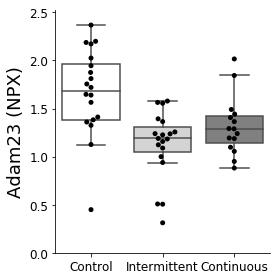

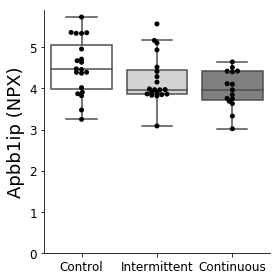

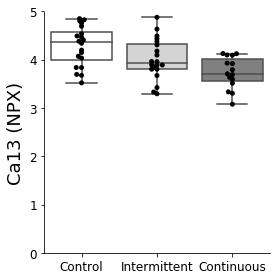

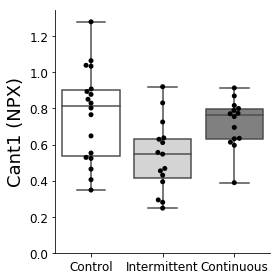

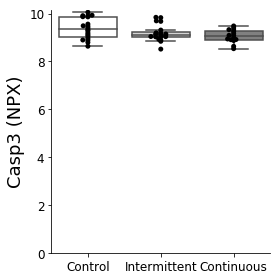

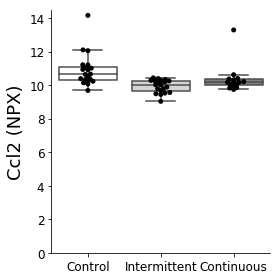

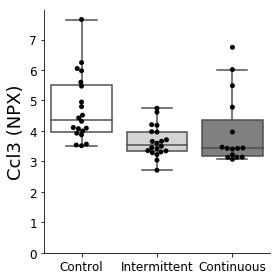

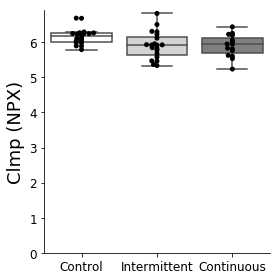

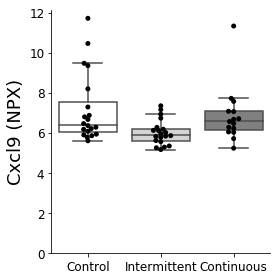

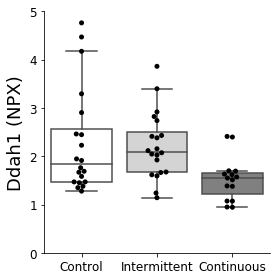

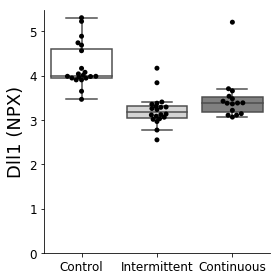

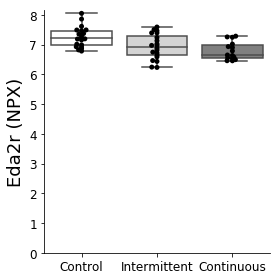

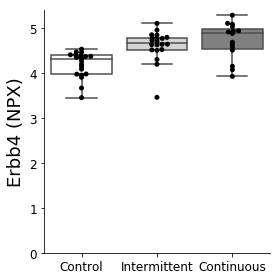

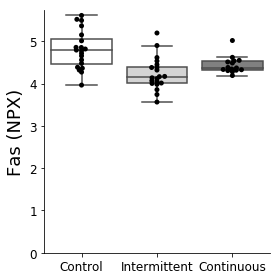

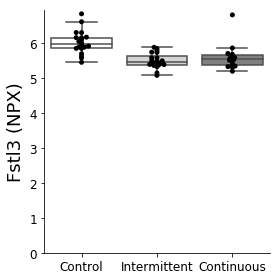

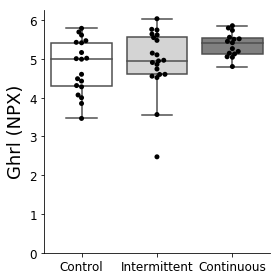

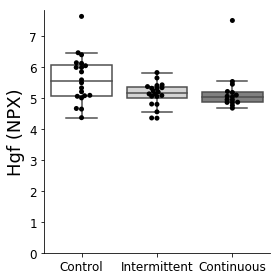

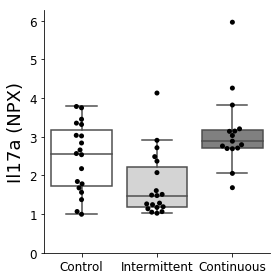

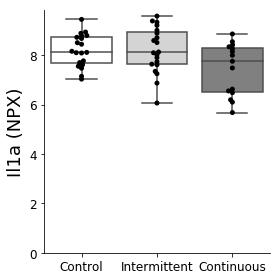

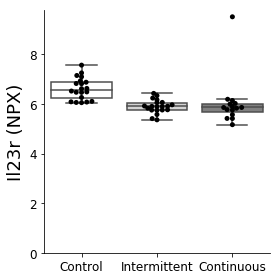

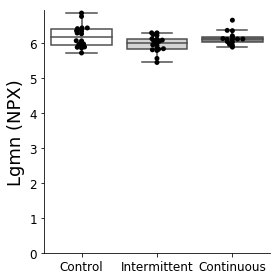

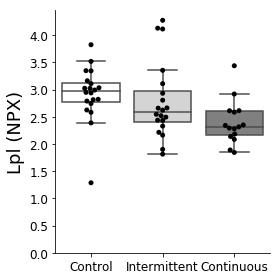

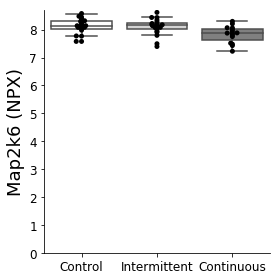

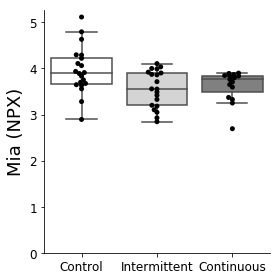

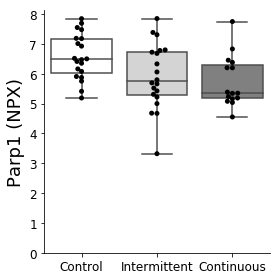

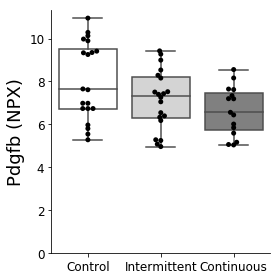

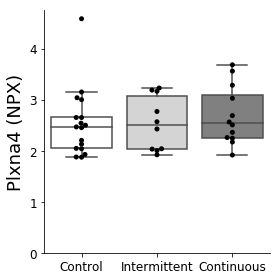

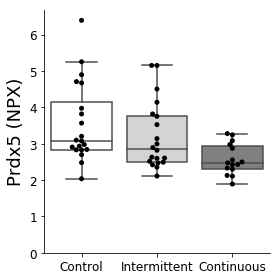

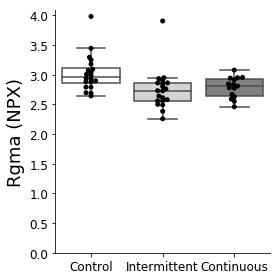

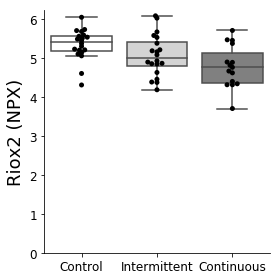

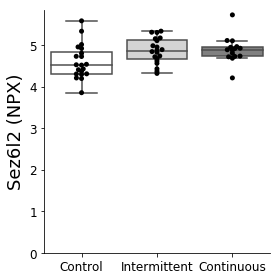

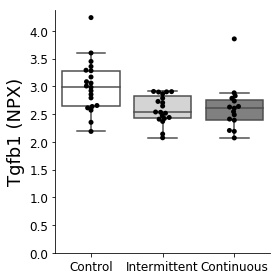

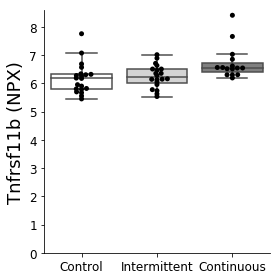

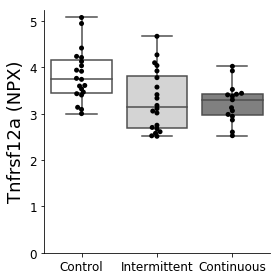

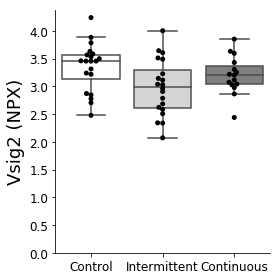

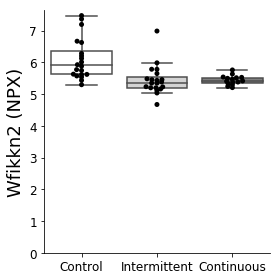

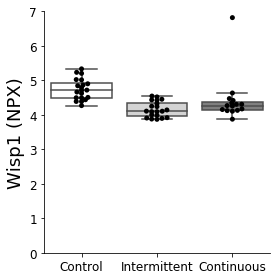

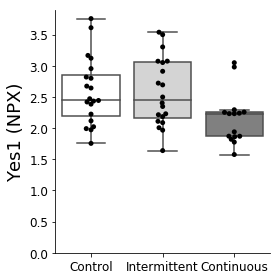

In [231]:
for gene in sig_genes:
    fig, ax = plt.subplots(figsize = (4,4))
    sns.boxplot(data = mer.loc[:, [gene, "Treatment"]].reset_index(), x = "Treatment", y = gene,
            order = ["Control", "Intermittent", "Continuous"], palette = palette, fliersize = 0)
    sns.swarmplot(data = mer.loc[:, [gene, "Treatment"]].reset_index(), x = "Treatment", y = gene,
            order = ["Control", "Intermittent", "Continuous"], color = "black")
    plt.ylabel(f"{gene} (NPX)")
    ax.yaxis.label.set_size(18)
    plt.ylim(0, None)
    plt.xlabel("")
    ax.tick_params(axis = "x", labelsize = 12)
    ax.tick_params(axis = "y", labelsize = 12)
    plt.style.context('seaborn-darkgrid')
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    matplotlib.rcParams['pdf.fonttype'] = 42
    plt.tight_layout()
    
    if run_type != "dry":
        plt.savefig("{}/SigGene_{}_{}_{}_{}.pdf".format(path, gene, sex, run_user, new_day))
    else:
        plt.show()

In [272]:
# Subset
subs = mer.loc[:, sig_genes + ["Treatment"]]

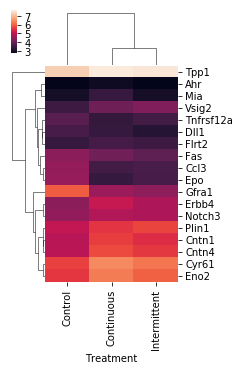

In [278]:
cm = sns.clustermap(subs.groupby("Treatment").median().T, figsize = (3, 5))
matplotlib.rcParams['pdf.fonttype'] = 42
#plt.tight_layout()
    
if run_type != "dry":
    cm.savefig("{}/HeatmapNPXvalues_{}_{}_{}.pdf".format(path, sex, run_user, new_day))
else:
    cm.show()

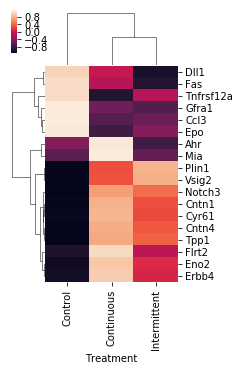

In [277]:
cm = sns.clustermap(subs.groupby("Treatment").median().T, figsize = (3, 5), z_score = 0)
matplotlib.rcParams['pdf.fonttype'] = 42
#plt.tight_layout()
    
if run_type != "dry":
    cm.savefig("{}/HeatmapZscoreGene_{}_{}_{}.pdf".format(path, sex, run_user, new_day))
else:
    cm.show()